<a href="https://colab.research.google.com/github/adityawithdoublea/qstp_dl/blob/master/qstp_dl_cv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Image Classification using ResNet, Regularization and Data Augmentation in PyTorch**
Dataset used: STL-10

Importing the required modules and classes

In [ ]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torchvision.transforms as tt
import matplotlib
import matplotlib.pyplot as plt
from torchvision.datasets import STL10
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision import utils
%matplotlib inline

Downloading and visualizing the dataset

In [ ]:
dataset = STL10(root='./data', download=True, transform=tt.ToTensor())
test_dataset = STL10(root='./data', split ='test', transform=tt.ToTensor())

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ./data/stl10_binary.tar.gz to ./data


In [ ]:
train_ds = dataset
classes = train_ds.classes
len(train_ds),train_ds.data.shape,len(test_dataset),classes,len(classes)

(5000,
 (5000, 3, 96, 96),
 8000,
 ['airplane',
  'bird',
  'car',
  'cat',
  'deer',
  'dog',
  'horse',
  'monkey',
  'ship',
  'truck'],
 10)

In [ ]:
img, label = train_ds[0]
img_shape = img.shape
img_shape

torch.Size([3, 96, 96])

Label (numeric): 1
Label (textual): bird


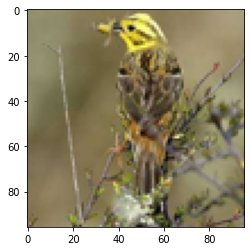

In [ ]:
img, label = train_ds[0]
plt.imshow(img.permute((1, 2, 0)))
print('Label (numeric):', label)
print('Label (textual):', classes[label])

In [ ]:
count_class = {}
for _,in_class in dataset: 
    labels = classes[in_class]
    if labels not in count_class:
        count_class[labels] = 0
    count_class[labels] += 1 
count_class 

{'airplane': 500,
 'bird': 500,
 'car': 500,
 'cat': 500,
 'deer': 500,
 'dog': 500,
 'horse': 500,
 'monkey': 500,
 'ship': 500,
 'truck': 500}

### There are a few important changes we'll make while creating PyTorch datasets for training and validation:

1. **Use test set for validation:** Instead of setting aside a fraction of the data from the training set for validation, we'll use the test set as our validation set. This gives a little more data to train with. 
2.   **Channel-wise data normalization:** This prevents the values from any one channel from disproportionately affecting the losses and gradients while training, simply by having a higher or wider range of values than others.
3. **Randomized data augmentations:** We will apply randomly chosen transformations while loading images from the training dataset. Since the transformation will be applied randomly and dynamically each time a particular image is loaded, the model sees slightly different images in each epoch of training, which allows it generalize better.



In [ ]:
#using random seed to get same random validation set
torch.manual_seed(69)
val_size = 1500
test_size = len(test_dataset) - val_size
test_ds, val_ds = random_split(test_dataset, [test_size, val_size])
len(test_ds), len(val_ds)

(6500, 1500)

image indices: [4041 2667 1626  439]
torch.Size([3, 100, 394])


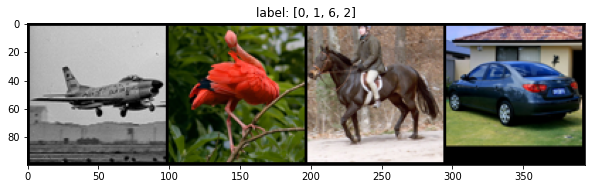

In [ ]:
np.random.seed(69)

def show(img,y=None,color=True):
    npimg = img.numpy()
    npimg_tr=np.transpose(npimg, (1,2,0))
    plt.imshow(npimg_tr)
    if y is not None:
        plt.title("label: "+str(y))
        
grid_size=4
rnd_inds=np.random.randint(0,len(train_ds),grid_size)
print("image indices:",rnd_inds)

x_grid=[train_ds[i][0] for i in rnd_inds]
y_grid=[train_ds[i][1] for i in rnd_inds]

x_grid=utils.make_grid(x_grid, nrow=4, padding=2)
print(x_grid.shape)

plt.figure(figsize=(10,10))
show(x_grid,y_grid)

image indices: [1344  255  277   58]
torch.Size([3, 100, 394])


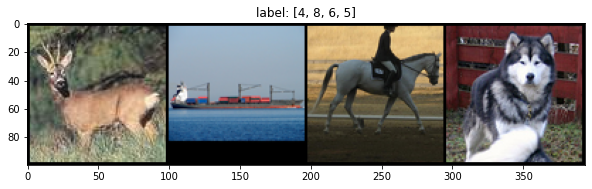

In [ ]:
np.random.seed(69)

grid_size=4
rnd_inds=np.random.randint(0,len(val_ds),grid_size)
print("image indices:",rnd_inds)

x_grid=[val_ds[i][0] for i in rnd_inds]
y_grid=[val_ds[i][1] for i in rnd_inds]

x_grid=utils.make_grid(x_grid, nrow=4, padding=2)
print(x_grid.shape)

plt.figure(figsize=(10,10))
show(x_grid,y_grid)

In [ ]:
#rgb mean and std 
meanRGB=[np.mean(x.numpy(),axis=(1,2)) for x,_ in train_ds]
stdRGB=[np.std(x.numpy(),axis=(1,2)) for x,_ in train_ds]

meanR=np.mean([m[0] for m in meanRGB])
meanG=np.mean([m[1] for m in meanRGB])
meanB=np.mean([m[2] for m in meanRGB])

stdR=np.mean([s[0] for s in stdRGB])
stdG=np.mean([s[1] for s in stdRGB])
stdB=np.mean([s[2] for s in stdRGB])

print(meanR,meanG,meanB)
print(stdR,stdG,stdB)

0.4467106 0.43980986 0.40664646
0.22414584 0.22148906 0.22389975


In [ ]:
#data transformation
stats = ((meanR,meanG,meanB), (stdR,stdG,stdB))
train_tf = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(p=0.5),
                         tt.RandomVerticalFlip(p=0.5), 
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])
val_tf = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [ ]:
#PyTorch datasets
train_ds.tt =  train_tf
val_ds.tt =  val_tf

Having batch size greater than 200 caused GPU memory allocation issues. 

In [ ]:
batch_size = 200

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


To display the images, we'll need to denormalize the pixels values to bring them back into the range (0,1).

In [ ]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

The grey tone is the result of normalization. If looked closely, one can see the cropping and reflection padding in some of the images.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


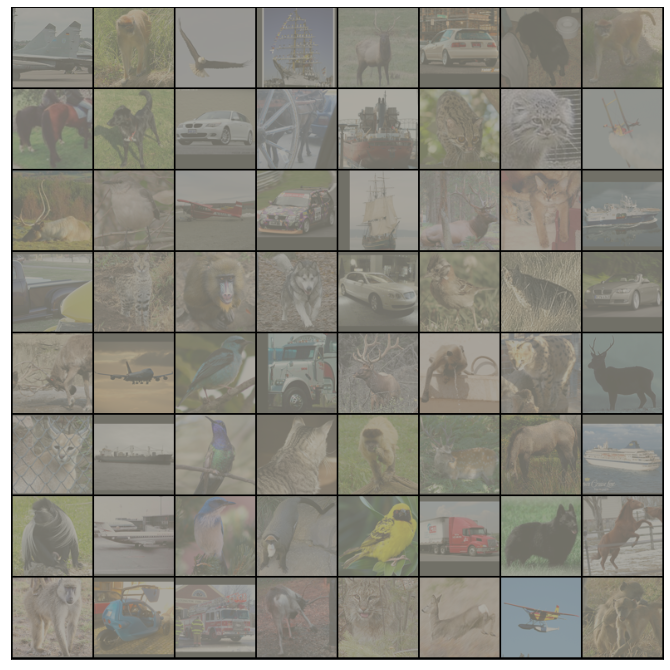

In [ ]:
show_batch(train_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


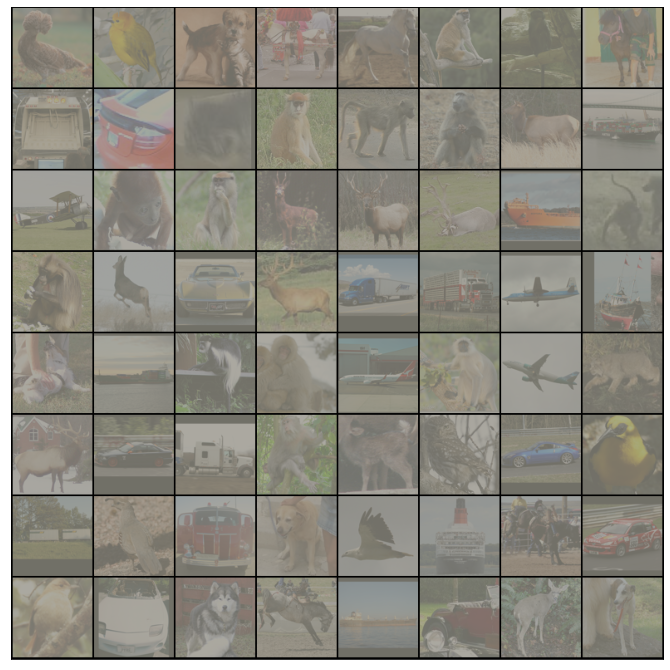

In [ ]:
show_batch(val_dl)

## **Using a GPU**
We'll have to define two helper functions, `get_default_device()` and `to_device()`, and a helper class `DeviceDataLoader()` to move our model & data to the GPU before training.

In [ ]:
#choosing gpu if available
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

#moving data and model to gpu
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

#constructing helper class dataloader
class DeviceDataLoader():

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):

        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        
        return len(self.dl)

In [ ]:
#if a GPU is selected, the device type will be 'cuda' 
device = get_default_device()
device

device(type='cuda')

Using **DeviceDataLoader** to automatically transfer batches of training and validation data to the GPU (if available).

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [ ]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input

In [ ]:
simple_resnet = to_device(SimpleResidualBlock(), device)

for images, labels in train_dl:
    out = simple_resnet(images)
    print(out.shape)
    break
    
del simple_resnet, images, labels
torch.cuda.empty_cache()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([200, 3, 96, 96])


### We are going to use the **ResNet 9** architecture

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64,pool=True)
        self.conv2 = conv_block(64, 128, pool=True) # output: 128 x 24 x 24
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True) # output: 256 x 12 x 12
        self.conv4 = conv_block(256, 512, pool=True) # output: 512 x 6 x 6
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(6), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
model = to_device(ResNet9(3, 10), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e

# **Training the model**
### Before training, we're going to make a bunch of changes to our fit function:

1. **Learning rate scheduling:** Instead of using a fixed learning rate, we will use a learning rate scheduler, which will change the learning rate after every batch of training. We'll implement the **"One Cycle Learning Rate Policy"**.

2. **Weight decay:**We also use weight decay (to prevent the weights from becoming too large) by adding an additional term to our loss function.

3. **Gradient clipping:** We'll limit the values of gradients to a small range to prevent undesirable changes in parameters due to large gradient values.

We'll define `fit_one_cycle ` function to incorporate these changes and also record the learning rate used for each batch.

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    #setting up a custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    #setting up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        #training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            #gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            #record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        #validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
torch.cuda.empty_cache()
history = [evaluate(model, val_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.09562500566244125, 'val_loss': 2.303051233291626}]

We'll use the Adam optimizer which uses techniques like momentum and adaptive learning rates for faster training. 

In [ ]:
torch.cuda.empty_cache()
epochs = 32
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], last_lr: 0.00064, train_loss: 2.1177, val_loss: 2.8408, val_acc: 0.1802
Epoch [1], last_lr: 0.00136, train_loss: 1.5100, val_loss: 2.0852, val_acc: 0.3298
Epoch [2], last_lr: 0.00250, train_loss: 1.3276, val_loss: 2.8413, val_acc: 0.3142
Epoch [3], last_lr: 0.00392, train_loss: 1.1843, val_loss: 2.5125, val_acc: 0.3744
Epoch [4], last_lr: 0.00548, train_loss: 1.1483, val_loss: 2.2039, val_acc: 0.3963
Epoch [5], last_lr: 0.00701, train_loss: 1.2252, val_loss: 3.1026, val_acc: 0.3504
Epoch [6], last_lr: 0.00835, train_loss: 1.2862, val_loss: 1.8428, val_acc: 0.4379
Epoch [7], last_lr: 0.00935, train_loss: 1.1249, val_loss: 1.6031, val_acc: 0.4513
Epoch [8], last_lr: 0.00991, train_loss: 1.0662, val_loss: 2.9265, val_acc: 0.4073
Epoch [9], last_lr: 0.00999, train_loss: 0.9130, val_loss: 2.3352, val_acc: 0.3102
Epoch [10], last_lr: 0.00990, train_loss: 0.7852, val_loss: 1.7718, val_acc: 0.4679
Epoch [11], last_lr: 0.00972, train_loss: 0.6778, val_loss: 2.7906, val_acc: 0.3792
Ep

In [ ]:
train_time='8:13'

Our model managed to get an accuracy of around 80% in 8 minutes. Let's plot the validation set accuracies,training and validation losses to study how the model improves over time.



In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs No. of epochs');

It's clear that after 25 epochs there's not much improvement. Lowering the epochs to 25 will allow us to reach the same accuracy in less training time.

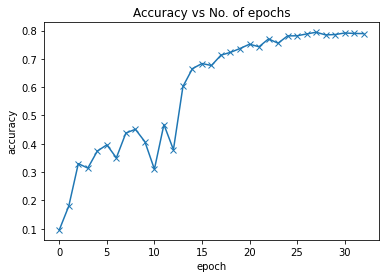

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs No. of epochs');

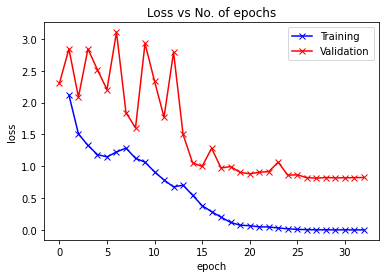

In [ ]:
plot_losses(history)

Let's visualize how the learning rate changed over time, batch-by-batch over all the epochs.

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

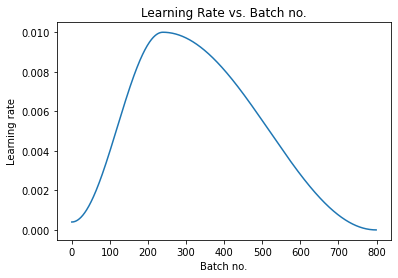

In [ ]:
plot_lrs(history)

The learning rate starts at a low value, and gradually increases for 30% of the iterations to a maximum value of 0.01, and then gradually decreases to a very small value.

Let's test out our model with some images from the predefined test dataset of 10000 images.

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

Label: bird , Predicted: bird


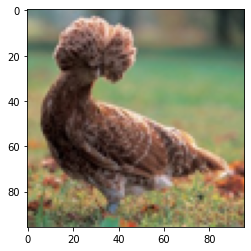

In [ ]:
img, label = val_ds[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: cat , Predicted: cat


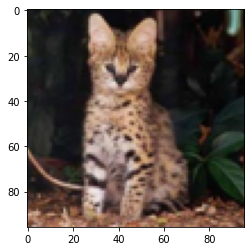

In [ ]:
img, label = val_ds[256]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: airplane , Predicted: truck


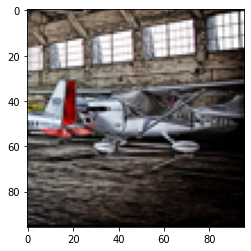

In [ ]:
img, label = val_ds[512]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))